In [1]:
%tensorflow_version 2.x
import tensorflow
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from google.colab import drive
%matplotlib inline
import cv2
from google.colab.patches import cv2_imshow
from scipy.signal import convolve2d 
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

In [2]:
warnings.filterwarnings("ignore")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Import the libraries, load datasets, print shape of data, visualize the images in dataset.**

In [3]:
imagesArray = np.load('/content/drive/MyDrive/aiml/ComputerVisionProject/images.npy')
labels = pd.read_csv('/content/drive/MyDrive/aiml/ComputerVisionProject/Labels.csv')
label_values = labels.values

In [4]:
# This is numpy array with the size of 233472000 = 128 * 128 * 3 * 4750. This implies 4750 color 128 x 128 images.
print(imagesArray.size)
print(label_values.size)

233472000
4750


In [5]:
imagesArray[0]

array([[[ 35,  52,  78],
        [ 36,  49,  76],
        [ 31,  45,  69],
        ...,
        [ 78,  95, 114],
        [ 76,  93, 110],
        [ 80,  95, 109]],

       [[ 33,  46,  68],
        [ 37,  50,  73],
        [ 48,  65,  83],
        ...,
        [ 81,  96, 113],
        [ 74,  89, 105],
        [ 83,  95, 109]],

       [[ 34,  50,  68],
        [ 35,  52,  72],
        [ 70,  85, 101],
        ...,
        [ 83,  97, 112],
        [ 79,  94, 108],
        [ 79,  94, 107]],

       ...,

       [[ 35,  50,  69],
        [ 42,  57,  73],
        [ 42,  57,  72],
        ...,
        [ 60,  76,  92],
        [ 67,  81,  97],
        [ 64,  77,  95]],

       [[ 36,  52,  67],
        [ 48,  63,  78],
        [ 41,  57,  73],
        ...,
        [ 44,  66,  83],
        [ 58,  76,  91],
        [ 57,  74,  90]],

       [[ 44,  58,  70],
        [ 43,  57,  73],
        [ 40,  55,  72],
        ...,
        [ 41,  70,  92],
        [ 55,  78,  97],
        [ 61,  79,  96]]

['Small-flowered Cranesbill']


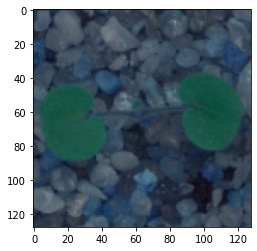

In [6]:
print(label_values[0])
plt.imshow(imagesArray[0], cmap='gray')

['Small-flowered Cranesbill']


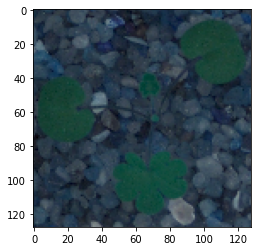

In [7]:
print(label_values[1])
plt.imshow(imagesArray[1], cmap='gray')

['Small-flowered Cranesbill']


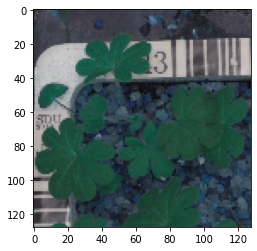

In [8]:
print(label_values[3])
plt.imshow(imagesArray[3], cmap='gray')

['Scentless Mayweed']


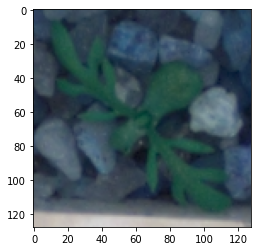

In [9]:
print(label_values[3000])
plt.imshow(imagesArray[3000], cmap='gray')

In [10]:
print (imagesArray.shape)
print (labels.size)

(4750, 128, 128, 3)
4750


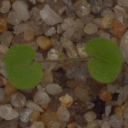

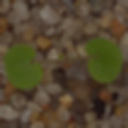

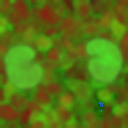

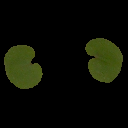

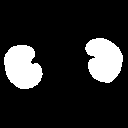

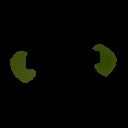

(128, 128, 3) (128, 128, 3) (128, 128, 3)


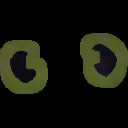

In [11]:
# Try with the single image to see how the HSV image look like
dst = cv2.GaussianBlur(imagesArray[0],(5,5),cv2.BORDER_DEFAULT)
hsvImg = cv2.cvtColor(dst, cv2.COLOR_BGR2HSV)
#hsvImg = cv2.cvtColor(imagesArray[0], cv2.COLOR_BGR2HSV)
cv2_imshow(imagesArray[0])
cv2_imshow(dst)
cv2_imshow(hsvImg)
low_green = np.array([30, 50, 70])
high_green = np.array([120, 255, 255])
mask = cv2.inRange(hsvImg, low_green, high_green)
# Bitwise-AND mask and original image
hsvGreenImg = cv2.bitwise_and(imagesArray[0],imagesArray[0], mask= mask)
cv2_imshow(hsvGreenImg)
cv2_imshow(mask)

kernel = np.ones((11,11),np.uint8)
erosion = cv2.erode(hsvGreenImg,kernel,iterations = 1)
cv2_imshow(erosion)

print(imagesArray[0].shape, dst.shape, hsvImg.shape)

morph = cv2.morphologyEx(hsvGreenImg, cv2.MORPH_GRADIENT, kernel)
cv2_imshow(morph)


In [12]:
#e1 = (erosion - np.min(erosion)) / (np.max(erosion) - np.min(erosion))
e1 = (erosion - erosion.mean()) / erosion.std()
e2 = (e1 - np.min(e1)) / (np.max(e1) - np.min(e1))

print(e1.min(), e2.min())
print(e1.max(), e2.max())
print(e1.shape)

-0.21706540456933576 0.0
6.0635304749301016 1.0
(128, 128, 3)


In [13]:
e1.max()

6.0635304749301016

## **2. Data Pre-Processing - Normalization**

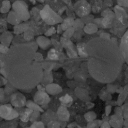

In [14]:
grayImg = cv2.cvtColor(imagesArray[0], cv2.COLOR_BGR2GRAY)
cv2_imshow(grayImg)

In [15]:
grayImg.shape

(128, 128)

In [16]:
# TO-DO: Go to http://dev.theomader.com/gaussian-kernel-calculator/ to make more kernels
kernel_gaussian_5 = np.array([[0.003765,0.015019,0.023792,0.015019,0.003765],
                   [0.015019,0.059912,0.094907,0.059912,0.015019],
                   [0.023792,0.094907,0.150342,0.094907,0.023792],
                   [0.015019,0.059912,0.094907,0.059912,0.015019],
                   [0.003765,0.015019,0.023792,0.015019,0.003765]])

In [17]:
kernel_gaussian_3 = np.array([[0.077847,0.123317,0.077847],
                   [0.123317,0.195346,0.123317],
                   [0.077847,0.123317,0.077847]])

In [18]:
kernel_gaussian_7 = np.array([[0.000036, 0.000363,	0.001446,	0.002291,	0.001446,	0.000363,	0.000036],
[0.000363,	0.003676,	0.014662,	0.023226,	0.014662,	0.003676,	0.000363],
[0.001446,	0.014662,	0.058488,	0.092651,	0.058488,	0.014662,	0.001446],
[0.002291,	0.023226,	0.092651,	0.146768,	0.092651,	0.023226,	0.002291],
[0.001446,	0.014662,	0.058488,	0.092651,	0.058488,	0.014662,	0.001446],
[0.000363,	0.003676,	0.014662,	0.023226,	0.014662,	0.003676,	0.000363],
[0.000036,	0.000363,	0.001446,	0.002291,	0.001446,	0.000363,	0.000036]])

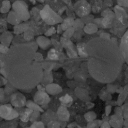

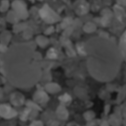

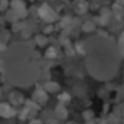

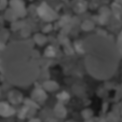

In [19]:
# Need to convert to gray scale to get 2D array and then use convovle 2d as opposed to running it directly on the first 3D image.
# 
imageBlurred_5 = convolve2d(grayImg, kernel_gaussian_5, mode = 'valid') 
imageBlurred_3 = convolve2d(grayImg, kernel_gaussian_3, mode = 'valid') 
imageBlurred_7 = convolve2d(grayImg, kernel_gaussian_7, mode = 'valid')
cv2_imshow(grayImg)
cv2_imshow(imageBlurred_3)
cv2_imshow(imageBlurred_5)
cv2_imshow(imageBlurred_7)

In [20]:
print(imageBlurred_3.shape, imageBlurred_5.shape, imageBlurred_7.shape)

(126, 126) (124, 124) (122, 122)


In [21]:
X_new = np.apply_along_axis(
    lambda grayImg: cv2.GaussianBlur(grayImg, (5, 5), 0), 
    -1, 
    grayImg
)

In [22]:
X_new.shape

(128, 128, 1)

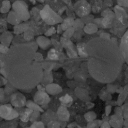

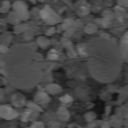

In [23]:
cv2_imshow(grayImg)
cv2_imshow(X_new)

In [24]:
imagesArray.shape

(4750, 128, 128, 3)

In [25]:
#imagesArray is the result of reading images.npy
#This will do guassian blur HSV color scheme, masking using low and high green.
hsvImages = []
for i, image in enumerate(imagesArray):
  blurImg = cv2.GaussianBlur(image,(5,5),cv2.BORDER_DEFAULT)
  hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)
  low_green = np.array([30, 50, 70])
  high_green = np.array([130, 255, 255])
  mask = cv2.inRange(hsvImg, low_green, high_green)
  # Bitwise-AND mask and original image
  hsvGreenImg = cv2.bitwise_and(blurImg,blurImg, mask= mask)
  hsvGreenImg = hsvGreenImg.astype('float32')
  hsvImages.append(hsvGreenImg)
  
hsvImagesArray = np.array(hsvImages)

In [26]:
hsvImagesArray.shape

(4750, 128, 128, 3)

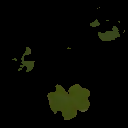

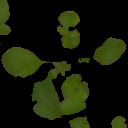

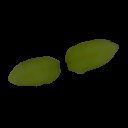

In [27]:
# Look at the images after converting to HSV scheme and masking. 
cv2_imshow(hsvImagesArray[1])
cv2_imshow(hsvImagesArray[1000])
cv2_imshow(hsvImagesArray[2000])

In [28]:
#Normalization
hsvImagesArray = hsvImagesArray.astype('float32')
#hsvImagesArray = (hsvImagesArray) - hsvImagesArray.mean() / hsvImagesArray.std()
# Look at the 4000 th image.
#print(hsvImagesArray[4000].min(), hsvImagesArray[4000].max())
hsvImagesArray = (hsvImagesArray - np.min(hsvImagesArray)) / (np.max(hsvImagesArray) - np.min(hsvImagesArray))
print(hsvImagesArray[4000].min(), hsvImagesArray[4000].max())



0.0 0.46153846


### **3. Make data comaptible**

In [29]:
type(labels)

pandas.core.frame.DataFrame

In [30]:
Y = labels

In [31]:
Y

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill
...,...
4745,Loose Silky-bent
4746,Loose Silky-bent
4747,Loose Silky-bent
4748,Loose Silky-bent


In [32]:
Y.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

In [33]:
labels

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill
...,...
4745,Loose Silky-bent
4746,Loose Silky-bent
4747,Loose Silky-bent
4748,Loose Silky-bent


In [34]:
Y = labels["Label"]
Y[0]

'Small-flowered Cranesbill'

In [35]:
labels.Label.unique()

array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

In [36]:
uniqueLabels = labels.Label.unique()

In [37]:
mappingLabelDigits = {}
for p in range(len(uniqueLabels)):
  mappingLabelDigits[uniqueLabels[p]] = p
print(mappingLabelDigits)

{'Small-flowered Cranesbill': 0, 'Fat Hen': 1, 'Shepherds Purse': 2, 'Common wheat': 3, 'Common Chickweed': 4, 'Charlock': 5, 'Cleavers': 6, 'Scentless Mayweed': 7, 'Sugar beet': 8, 'Maize': 9, 'Black-grass': 10, 'Loose Silky-bent': 11}


In [38]:
print(mappingLabelDigits)

{'Small-flowered Cranesbill': 0, 'Fat Hen': 1, 'Shepherds Purse': 2, 'Common wheat': 3, 'Common Chickweed': 4, 'Charlock': 5, 'Cleavers': 6, 'Scentless Mayweed': 7, 'Sugar beet': 8, 'Maize': 9, 'Black-grass': 10, 'Loose Silky-bent': 11}


In [39]:
labels_values = labels.values

In [40]:
for x in range(len(labels_values)):
  Y[x] = mappingLabelDigits[Y[x]]

In [41]:
ohe_label = to_categorical(Y)

In [42]:
#One hot vectors for the labels.
ohe_label

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [43]:
ohe_label[1000]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [44]:
X_train, X_test_validation, y_train, y_test_validation = train_test_split(hsvImagesArray, ohe_label, test_size = 0.3, random_state = 7)
X_test, X_validation, y_test, y_validation = train_test_split(X_test_validation, y_test_validation, test_size = 0.5, random_state = 7)

In [45]:
print (X_train.shape, y_train.shape)

(3325, 128, 128, 3) (3325, 12)


In [46]:
print (X_test.shape, y_test.shape)

(712, 128, 128, 3) (712, 12)


In [47]:
print (X_validation.shape, y_validation.shape)

(713, 128, 128, 3) (713, 12)


### Question 3d. The shape of the X_train and y_train is already compatible with the keras model.

### **4. Bulding CNN**

In [48]:
X_train.shape

(3325, 128, 128, 3)

In [49]:
classifier = Sequential()
# Add a Convolution layer with 64 kernels of 4x4 shape with activation function ReLU
classifier.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:], activation = 'relu', padding = 'same'))
# Add a Max Pooling layer of size 2X2
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
# Adding another pooling layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'valid'))
# Adding another pooling layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Flattening the layer before fully connected layers
classifier.add(Flatten())
# Adding a fully connected layer with 512 neurons
classifier.add(Dense(units = 128, activation = 'relu'))
# Adding dropout with probability 0.5
classifier.add(Dropout(0.5))
# Adding a fully connected layer with 128 neurons
classifier.add(Dense(units = 64, activation = 'relu'))
# The final output layer with 12 neurons to predict the categorical classifcation
classifier.add(Dense(units = 12, activation = 'softmax'))

In [50]:
classifier.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

### **5. Fit and evaluate model and print confusion matrix.**

In [51]:
classifier.fit( x=X_train, y=y_train, batch_size=32, epochs=30)

Epoch 1/30
104/104 [==============================] - 5s 20ms/step - loss: 2.2874 - accuracy: 0.2076
Epoch 2/30
104/104 [==============================] - 2s 18ms/step - loss: 1.7261 - accuracy: 0.4026
Epoch 3/30
104/104 [==============================] - 2s 18ms/step - loss: 1.5206 - accuracy: 0.4727
Epoch 4/30
104/104 [==============================] - 2s 18ms/step - loss: 1.2634 - accuracy: 0.5483
Epoch 5/30
104/104 [==============================] - 2s 18ms/step - loss: 1.0227 - accuracy: 0.6436
Epoch 6/30
104/104 [==============================] - 2s 18ms/step - loss: 0.8194 - accuracy: 0.7117
Epoch 7/30
104/104 [==============================] - 2s 18ms/step - loss: 0.7258 - accuracy: 0.7411
Epoch 8/30
104/104 [==============================] - 2s 18ms/step - loss: 0.6353 - accuracy: 0.7665
Epoch 9/30
104/104 [==============================] - 2s 18ms/step - loss: 0.5622 - accuracy: 0.7885
Epoch 10/30
104/104 [==============================] - 2s 18ms/step - loss: 0.4786 - accura

In [52]:
results_test = classifier.evaluate(X_test, y_test)
print(results_test)

23/23 [==============================] - 0s 8ms/step - loss: 1.7913 - accuracy: 0.6854
[1.7912706136703491, 0.6853932738304138]


In [53]:
results_validation = classifier.evaluate(X_validation, y_validation)
print(results_validation)

23/23 [==============================] - 0s 8ms/step - loss: 1.6295 - accuracy: 0.7237
[1.629478096961975, 0.7237026691436768]


In [54]:
#confusion_matrix(y_train.values, Y_train_pred)

In [55]:
Y_test_pred = classifier.predict_generator(X_test)
y_test_pred = np.argmax(Y_test_pred, axis=1)

In [56]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [57]:
y_test_pred

array([ 0,  4,  0,  6,  2,  9,  4,  8,  4,  8,  8, 11,  2,  4, 11, 11,  4,
        2,  5, 11, 10, 11, 11,  8,  9,  4,  4,  0, 11,  7,  4, 11,  0,  6,
       10,  1,  6,  8,  5,  9,  4,  0,  4,  6,  0, 10,  0,  2,  8,  8,  0,
        7,  4,  0,  2, 11, 11,  0,  5,  9,  5,  0,  6,  7,  8, 11,  0,  4,
        4,  4,  5,  4,  9,  1,  7,  5,  9, 11, 11, 10, 11,  4,  3, 11,  7,
        8,  7,  3,  4, 11,  5,  0,  7,  9,  1,  7,  7,  7,  5,  7,  9,  7,
        1,  3,  7,  1, 11, 11,  5,  5,  0, 11,  7,  0,  5,  7, 11,  5,  4,
       11, 11,  4,  0,  3,  7, 11,  4, 11,  1,  1,  6,  3,  8,  4,  6,  5,
        4,  4, 11,  6,  9, 11,  4,  7,  4,  0,  5, 11,  0,  9,  5,  0,  0,
        1,  6,  1,  7,  4,  2,  7,  0, 10, 11,  8,  9, 10, 10,  5,  3,  4,
        4,  4,  0, 11,  5, 10,  4,  8,  4, 10,  5,  7,  6,  1, 11,  5, 11,
        1,  9,  2,  7, 11,  5,  2,  1, 11, 10, 10,  4,  0,  0,  1, 11,  0,
        1,  7, 11, 11,  1,  3,  5,  7,  1, 10,  4,  7,  2,  2,  1, 10,  4,
       11,  5,  8,  8,  4

In [65]:
#convert the y_test back to classes and then print confusion matrix.
y_test_classes = np.argmax(y_test, axis=1)
print(confusion_matrix(y_test_classes, y_test_pred))
#All diagonal values are predicted correctly. 

[[68  2  1  0  3  1  0  1  1  1  0  0]
 [ 1 43  2  0  3  1  0  2  1  3  2 10]
 [ 1  2 22  0  4  0  1  4  1  3  0  0]
 [ 0  0  0  3  0  0  1  1  0  0  5 23]
 [ 0  1  2  0 79  0  0  4  0  1  0  0]
 [ 3  1  1  0  1 46  1  5  1  0  0  0]
 [ 1  2  0  0  1  0 18  3  1  0  2  6]
 [ 0  0  1  2  4  2  1 66  0  0  1  5]
 [ 3  0  0  0  1  0  3  2 42  1  1  2]
 [ 2  1  0  0  6  0  0  3  4 18  0  0]
 [ 1  1  0  3  0  0  1  1  2  0 10 31]
 [ 0  3  0  5  1  0  2  0  0  0 10 73]]


## **6. Visualize prediction for x_test[2], x_test[33], x_test[36], x_test[59]**

In [59]:
#{'Small-flowered Cranesbill': 0, 'Fat Hen': 1, 'Shepherds Purse': 2, 'Common wheat': 3, 'Common Chickweed': 4, 'Charlock': 5, 'Cleavers': 6, 'Scentless Mayweed': 7, 'Sugar beet': 8, 'Maize': 9, 'Black-grass': 10, 'Loose Silky-bent': 11}
# Model was able to correctly predict for x_test[3], x_test[33], x_test[59], but not x_test[2] and x_test[36]. They belong to class 6 (Cleavers) and 9 (Maize).

print("y_test_true[2] class = ", y_test_classes[2], "y_test_pred[2] class = ", y_test_pred[2])
print("y_test_true[3] class = ", y_test_classes[3], "y_test_pred[3] class = ", y_test_pred[3])
print("y_test_true[33] class = ", y_test_classes[33], "y_test_pred[33] class = ", y_test_pred[33])
print("y_test_true[36] class = ", y_test_classes[36], "y_test_pred[36] class = ", y_test_pred[36])
print("y_test_true[59] class = ", y_test_classes[59], "y_test_pred[59] class = ", y_test_pred[59])

y_test_true[2] class =  8 y_test_pred[2] class =  0
y_test_true[3] class =  6 y_test_pred[3] class =  6
y_test_true[33] class =  6 y_test_pred[33] class =  6
y_test_true[36] class =  10 y_test_pred[36] class =  6
y_test_true[59] class =  9 y_test_pred[59] class =  9


In [60]:
y_test_pred.size

712

In [61]:
y_test_classes.size

712

In [62]:
## Let us make sure the reverse one hot coding ouput matches with the accuracy of evaluate call.
## In this case, it does, 0.64...

y_test_matched = 0
y_test_unmatched = 0
for i in range(y_test_pred.size):
    if (y_test_pred[i] == y_test_classes[i]) :
      y_test_matched += 1
    else :
      y_test_unmatched += 1

print("y_test matched", y_test_matched)
print("y_tets unmatched", y_test_unmatched)

y_test matched 488
y_tets unmatched 224


In [63]:
print(y_test_matched / y_test_pred.size)

0.6853932584269663
